In [131]:
# 导入 psi4
import psi4

In [132]:
psi4.set_output_file('output.dat', False)

PosixPath('output.dat')

In [133]:
psi4.set_memory('500 MB')

500000000

In [134]:
h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

In [135]:
%%time
energy = psi4.energy('scf/cc-pvdz')
print("Computed HF energy:", energy)

Computed HF energy: -76.02663273509017
CPU times: user 291 ms, sys: 12 ms, total: 303 ms
Wall time: 309 ms


In [136]:
R = 1.075  # 键长，单位为 Å
A = 133.93  # 键角，单位为度

In [137]:
ch2 = psi4.geometry("""
0 3
C
H 1 {0}
H 1 {0} 2 {1}
""".format(R, A))

In [138]:
psi4.set_options({'reference': 'uhf'})

In [139]:
%%time
ch2_energy = psi4.energy('scf/6-31g**')
print("Computed UHF energy for CH2:", ch2_energy)

Computed UHF energy for CH2: -38.925334628937065
CPU times: user 278 ms, sys: 5.16 ms, total: 284 ms
Wall time: 285 ms


In [140]:
psi4.set_options({'reference': 'rhf'})

In [141]:
%%time
optimized_energy = psi4.optimize('scf/cc-pvdz', molecule=h2o)
print("Optimized HF energy for H2O:", optimized_energy)

Optimizer: Optimization complete!
Optimized HF energy for H2O: -76.0270327293733
CPU times: user 823 ms, sys: 13.8 ms, total: 837 ms
Wall time: 883 ms


In [142]:
%%time
scf_e, scf_wfn = psi4.frequency('scf/cc-pvdz', molecule=h2o, return_wfn=True)
print("Vibrational frequencies for optimized H2O calculated.")

Vibrational frequencies for optimized H2O calculated.
CPU times: user 983 ms, sys: 13.8 ms, total: 997 ms
Wall time: 1 s


In [143]:
dimer = psi4.geometry("""
0 1
C   0.000000  -0.667578  -2.124659
C   0.000000   0.667578  -2.124659
H   0.923621  -1.232253  -2.126185
H  -0.923621  -1.232253  -2.126185
H  -0.923621   1.232253  -2.126185
H   0.923621   1.232253  -2.126185
--
0 1
C   0.000000   0.000000   2.900503
C   0.000000   0.000000   1.693240
H   0.000000   0.000000   0.627352
H   0.000000   0.000000   3.963929
units angstrom
""")

In [144]:
psi4.set_options({
    'scf_type': 'df',
    'freeze_core': True
})

In [145]:
%%time
sapt_energy = psi4.energy('sapt0/jun-cc-pvdz', molecule=dimer)
print("SAPT0 interaction energy for ethylene-acetylene dimer:", sapt_energy)

SAPT0 interaction energy for ethylene-acetylene dimer: -0.0022355823909805178
CPU times: user 3.71 s, sys: 193 ms, total: 3.9 s
Wall time: 4 s


In [146]:
ne2_geometry = """
Ne
--
Ne 1 {0}
"""

In [147]:
psi4.set_options({'freeze_core': True})

In [148]:
Rvals = [2.5, 3.0, 4.0]

In [149]:
ecp = {}

In [150]:
for R in Rvals:
    ne2 = psi4.geometry(ne2_geometry.format(R))  # 设置当前距离的几何结构
    ecp[R] = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ne2)  # 计算 CP 校正能量

In [151]:
print("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    print("            {:3.1f}                        {:1.6f}".format(R, e))

CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies

          R [Ang]                 E_int [kcal/mol]       
---------------------------------------------------------
            2.5                        0.758605
            3.0                        0.015968
            4.0                        -0.016215


In [152]:
psi4.core.print_out("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
psi4.core.print_out("          R [Ang]                 E_int [kcal/mol]       \n")
psi4.core.print_out("---------------------------------------------------------\n")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    psi4.core.print_out("            {:3.1f}                        {:1.6f}\n".format(R, e))

Fitted parameters - Sigma: 3.6436102681963995, Epsilon: 0.12033427583805124


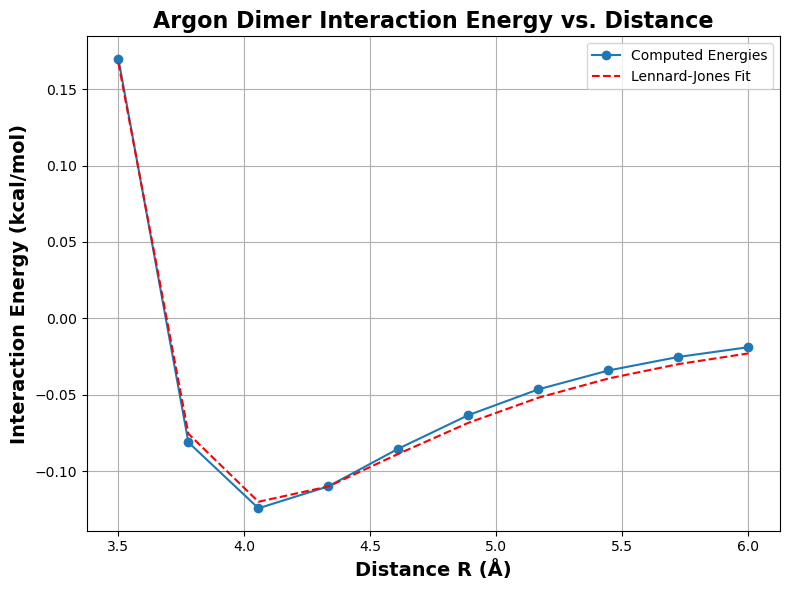

In [153]:
# 导入所需库
import psi4
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 定义 Lennard-Jones 势函数
def lj(r, sigma, eps):
    return 4 * eps * ((sigma / r)**12 - (sigma / r)**6)

# 定义 Psi4 设置
psi4.set_options({'freeze_core': True})

# 距离范围和空列表来存储能量
Rvals = np.linspace(3.5, 6.0, 10)  # 3.5 Å 到 6.0 Å 之间的10个点
energies = []

# 氩二聚体的几何结构模板
ar2_geometry = """
Ar
--
Ar 1 {0}
"""

# 计算每个距离下的能量
for R in Rvals:
    ar2 = psi4.geometry(ar2_geometry.format(R))
    energy = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ar2)
    energies.append(energy * psi4.constants.hartree2kcalmol)  # 将能量转换为 kcal/mol

# 转换为 NumPy 数组，方便后续处理
energies = np.array(energies)

# 使用 curve_fit 拟合 Lennard-Jones 势，并给出初始参数估计值
initial_guess = [4.0, -0.1]  # 初始值: sigma = 4.0 Å, epsilon = -0.1 kcal/mol
params, _ = curve_fit(lj, Rvals, energies, p0=initial_guess)
sigma, eps = params  # 获得拟合的 sigma 和 eps 参数
print(f"Fitted parameters - Sigma: {sigma}, Epsilon: {eps}")

# 生成拟合曲线的能量值
fitted_energies = lj(Rvals, sigma, eps)

# 绘制图像，连接所有点
plt.figure(figsize=(8, 6))
plt.plot(Rvals, energies, 'o-', label="Computed Energies")      # 实心圆点表示计算的能量值并连接
plt.plot(Rvals, fitted_energies, 'r--', label="Lennard-Jones Fit")  # 虚线表示拟合的LJ曲线
plt.xlabel("Distance R (Å)", fontsize=14, fontweight='bold')
plt.ylabel("Interaction Energy (kcal/mol)", fontsize=14, fontweight='bold')
plt.title("Argon Dimer Interaction Energy vs. Distance", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 保存图像到当前文件夹
plt.savefig("argon_dimer_interaction_energy.png", dpi=300)
plt.show()

In [ ]:
# 导入所需库
import psi4
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 定义 Lennard-Jones 势函数
def lj(r, sigma, eps):
    return 4 * eps * ((sigma / r)**12 - (sigma / r)**6)

# 定义 Psi4 设置
psi4.set_options({'freeze_core': True})

# 距离范围和空列表来存储能量
Rvals = np.linspace(3.5, 6.0, 30)  # 3.5 Å 到 6.0 Å 之间的30个点
energies = []

# 氩二聚体的几何结构模板
ar2_geometry = """
Ar
--
Ar 1 {0}
"""

# 计算每个距离下的能量
for R in Rvals:
    ar2 = psi4.geometry(ar2_geometry.format(R))
    energy = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ar2)
    energies.append(energy * psi4.constants.hartree2kcalmol)  # 将能量转换为 kcal/mol

# 转换为 NumPy 数组，方便后续处理
energies = np.array(energies)

# 使用 curve_fit 拟合 Lennard-Jones 势，并给出初始参数估计值
initial_guess = [4.0, -0.1]  # 初始值: sigma = 4.0 Å, epsilon = -0.1 kcal/mol
params, _ = curve_fit(lj, Rvals, energies, p0=initial_guess)
sigma, eps = params  # 获得拟合的 sigma 和 eps 参数
print(f"Fitted parameters - Sigma: {sigma}, Epsilon: {eps}")

# 生成拟合曲线的能量值
fitted_energies = lj(Rvals, sigma, eps)

# 绘制图像，连接所有点
plt.figure(figsize=(8, 6))
plt.plot(Rvals, energies, 'o-', label="Computed Energies")      # 实心圆点表示计算的能量值并连接
plt.plot(Rvals, fitted_energies, 'r--', label="Lennard-Jones Fit")  # 虚线表示拟合的LJ曲线
plt.xlabel("Distance R (Å)", fontsize=14, fontweight='bold')
plt.ylabel("Interaction Energy (kcal/mol)", fontsize=14, fontweight='bold')
plt.title("Argon Dimer Interaction Energy vs. Distance", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 保存图像到当前文件夹，文件名包含 "30_points"
plt.savefig("argon_dimer_interaction_energy_30_points.png", dpi=300)
plt.show()